<a href="https://colab.research.google.com/github/stellajiangggg/Project-Ai/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Mount Google Drive & Install Dependencies

In this step, we mount Google Drive to access data files stored in the cloud, and install the required Python packages for remote sensing and machine learning analysis. These packages include:

- **rasterio**: For reading and processing geospatial raster data (e.g., Sentinel-2 bands).
- **scikit-learn**: For clustering (K-Means), classification (Random Forest), and dimensionality reduction (PCA, UMAP).
- **geopandas**: For handling geographic vector data (if needed).
- **shap**: For future explainability (SHAP values) if required.
- **matplotlib**: For data visualization.

This ensures the runtime environment is ready to execute the rest of the analysis pipeline.


In [1]:
# 1) MOUNT DRIVE & INSTALL DEPENDENCIES

from google.colab import drive
drive.mount('/content/drive')

!pip install rasterio scikit-learn geopandas shap matplotlib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Imports & Helper Functions

In this section, we import essential libraries for geospatial data handling, machine learning, and visualization.

### Imported Modules
- **os** / **numpy**: File operations and numerical computations
- **matplotlib.pyplot** / **seaborn**: Data visualization
- **rasterio**: Reading and manipulating geospatial raster datasets (e.g., Sentinel-2 bands)
- **scikit-learn**: For clustering (K-Means), classification (Random Forest), and model evaluation

### Defined Helper Functions
- `read_band_subset(path, window=None)`:  
  Reads a cropped window (default: 2000x2000 pixels) from a .jp2 Sentinel-2 band file using Rasterio. Returns both the image array and updated metadata.
  
- `compute_ndvi(nir, red)`:  
  Computes the **Normalized Difference Vegetation Index (NDVI)** as:  
  \[
  \text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red} + \varepsilon}
  \]
  Useful for detecting vegetation health and density.

- `compute_ndwi(green, nir)`:  
  Computes the **Normalized Difference Water Index (NDWI)**:  
  \[
  \text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR} + \varepsilon}
  \]
  Effective in identifying water bodies.

- `stretch(img, pmin=2, pmax=98)`:  
  Applies percentile contrast stretching for image normalization. Enhances image visibility in plotting by clipping the extremes.

These modular functions streamline data preparation and enhance reproducibility across different geographic scenes.



In [2]:
# 2) IMPORTS & HELPER FUNCTIONS

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.enums import Resampling
from rasterio.windows import Window
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report
)

# Reads a subset (window) of a band from a .jp2 file
def read_band_subset(path, window=None):
    """
    Reads a subset of the image at 'path'.
    If 'window' is None, we default to a 2000 x 2000 crop
    from the top-left corner.

    Returns:
      arr (np.float32): shape (window.height, window.width)
      profile (dict)  : updated profile for the subset
    """
    if window is None:
        # 2000x2000 top-left is the default
        window = Window(0, 0, 2000, 2000)

    with rasterio.open(path) as src:
        arr = src.read(1, window=window).astype('float32')
        profile = src.profile.copy()
        profile.update({
            'height': window.height,
            'width': window.width,
            'transform': rasterio.windows.transform(window, src.transform),
        })
    return arr, profile

def compute_ndvi(nir, red):
    """
    NDVI = (NIR - Red) / (NIR + Red + small_epsilon).
    """
    return (nir - red) / (nir + red + 1e-6)

def compute_ndwi(green, nir):
    """
    NDWI = (Green - NIR) / (Green + NIR + small_epsilon).
    """
    return (green - nir) / (green + nir + 1e-6)

def stretch(img, pmin=2, pmax=98):
    """
    Simple percentile stretch for visualization.
    """
    min_val, max_val = np.percentile(img, [pmin, pmax])
    return np.clip((img - min_val) / (max_val - min_val), 0, 1)

## 3.1 Define Sentinel-2 Band Paths

This section defines absolute file paths to the Sentinel-2 imagery used in the analysis. Both Level-1C (top-of-atmosphere reflectance) and Level-2A (surface reflectance, atmospherically corrected) datasets are used.

These band paths point to key spectral channels required for vegetation and water index calculations:

### Level-1C Band Paths
- `L1C_B02_PATH`: Band 2 (Blue)
- `L1C_B04_PATH`: Band 4 (Red)
- `L1C_B08_PATH`: Band 8 (Near-Infrared)


### Level-2A Band Paths
- `L2A_B02_PATH`: Band 2 (Blue, 10m resolution)
- `L2A_B04_PATH`: Band 4 (Red, 10m resolution)
- `L2A_B08_PATH`: Band 8 (NIR, 10m resolution)



In [3]:


L1C_B02_PATH = '/content/drive/MyDrive/final ai/S2A_MSIL1C_20250501T100041_N0511_R122_T33TUJ_20250501T151719.SAFE/GRANULE/L1C_T33TUJ_A051485_20250501T100402/IMG_DATA/T33TUJ_20250501T100041_B02.jp2'
L1C_B04_PATH = '/content/drive/MyDrive/final ai/S2A_MSIL1C_20250501T100041_N0511_R122_T33TUJ_20250501T151719.SAFE/GRANULE/L1C_T33TUJ_A051485_20250501T100402/IMG_DATA/T33TUJ_20250501T100041_B04.jp2'
L1C_B08_PATH = '/content/drive/MyDrive/final ai/S2A_MSIL1C_20250501T100041_N0511_R122_T33TUJ_20250501T151719.SAFE/GRANULE/L1C_T33TUJ_A051485_20250501T100402/IMG_DATA/T33TUJ_20250501T100041_B08.jp2'

L2A_B02_PATH = '/content/drive/MyDrive/final ai/S2C_MSIL2A_20250519T100041_N0511_R122_T33TUJ_20250519T151359.SAFE 2/GRANULE/L2A_T33TUJ_A003667_20250519T100043/IMG_DATA/R10m/T33TUJ_20250519T100041_B02_10m.jp2'
L2A_B04_PATH = '/content/drive/MyDrive/final ai/S2C_MSIL2A_20250519T100041_N0511_R122_T33TUJ_20250519T151359.SAFE 2/GRANULE/L2A_T33TUJ_A003667_20250519T100043/IMG_DATA/R10m/T33TUJ_20250519T100041_B04_10m.jp2'
L2A_B08_PATH = '/content/drive/MyDrive/final ai/S2C_MSIL2A_20250519T100041_N0511_R122_T33TUJ_20250519T151359.SAFE 2/GRANULE/L2A_T33TUJ_A003667_20250519T100043/IMG_DATA/R10m/T33TUJ_20250519T100041_B08_10m.jp2'

## 3.2 Read Subsets from Sentinel-2 Imagery

To reduce processing time and focus analysis on a consistent area, we define a spatial **crop window** and read a 2000×2000 pixel subset from each image.

```python
crop_window = Window(col_off=0, row_off=800, width=2000, height=2000)



In [4]:
crop_window = Window(0, 800, 2000, 2000)

# --- L1C Subsets ---
l1c_b02, l1c_profile_b02 = read_band_subset(L1C_B02_PATH, window=crop_window)
l1c_b04, l1c_profile_b04 = read_band_subset(L1C_B04_PATH, window=crop_window)
l1c_b08, l1c_profile_b08 = read_band_subset(L1C_B08_PATH, window=crop_window)

# --- L2A Subsets ---
l2a_b02, l2a_profile_b02 = read_band_subset(L2A_B02_PATH, window=crop_window)
l2a_b04, l2a_profile_b04 = read_band_subset(L2A_B04_PATH, window=crop_window)
l2a_b08, l2a_profile_b08 = read_band_subset(L2A_B08_PATH, window=crop_window)

## 4. Compute NDVI (L1C vs. L2A) and Visualize Differences

In this section, we compute the **Normalized Difference Vegetation Index (NDVI)** for both Level-1C and Level-2A imagery using the NIR (B08) and Red (B04) bands:

$$
\text{NDVI} = \frac{B08 - B04}{B08 + B04 + \varepsilon}
$$

The resulting NDVI maps represent vegetation greenness, with values closer to 1 indicating healthy vegetation and values near 0 or negative indicating sparse or no vegetation.

We then:
- Compare NDVI derived from **top-of-atmosphere reflectance (L1C)** and **surface reflectance (L2A)**.
- Compute the pixel-wise difference:

$$
\text{NDVI}_{\text{diff}} = \text{NDVI}_{\text{L2A}} - \text{NDVI}_{\text{L1C}}
$$

- Visualize NDVI for both products and their difference using a side-by-side matplotlib plot.

### Key Observations:
- **NDVI - L2A** generally shows smoother and higher values, as expected after atmospheric correction.
- The difference plot helps quantify the correction effect, particularly in vegetated areas.
- Mean and standard deviation of the NDVI difference are printed to summarize this shift.

A histogram of pixel-wise NDVI differences is also provided to assess the overall distribution.

> This analysis highlights the impact of atmospheric correction on NDVI values, which is critical for ensuring consistency in vegetation monitoring using Sentinel-2 data.


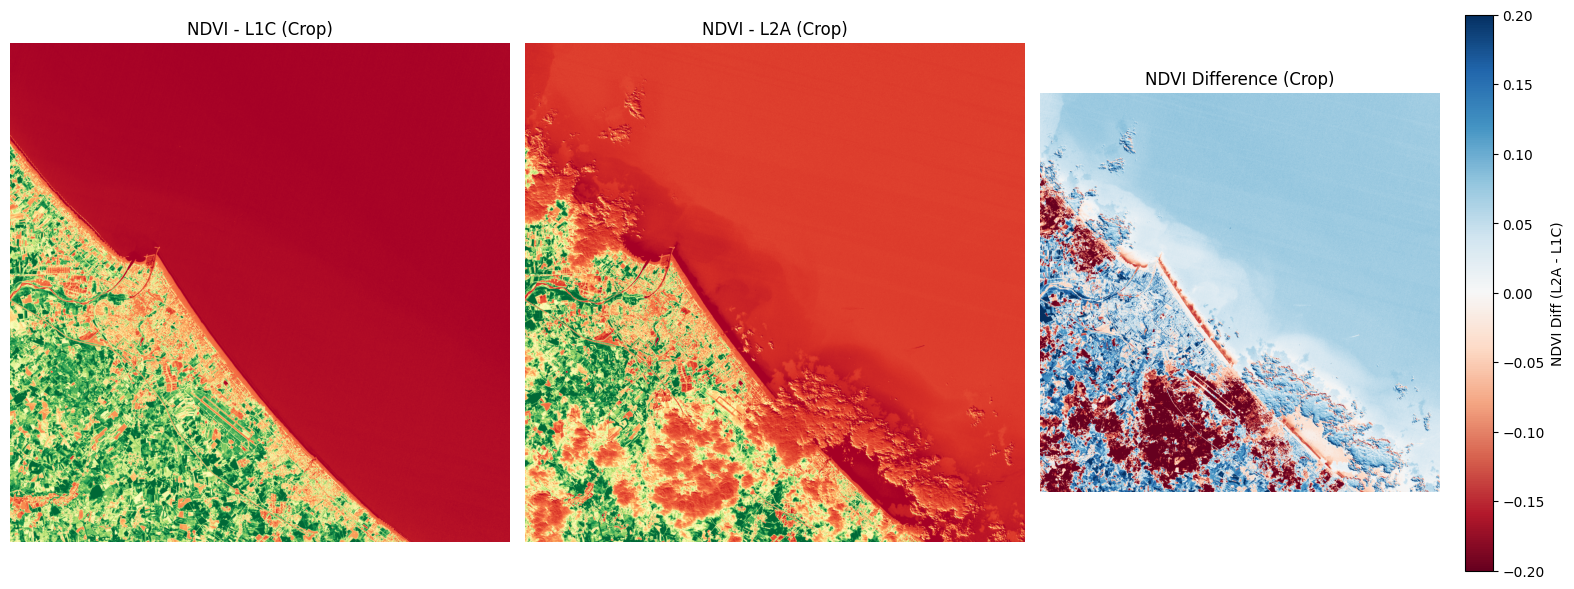

Mean NDVI difference (L2A - L1C): 0.0238
Std dev of NDVI difference: 0.1161


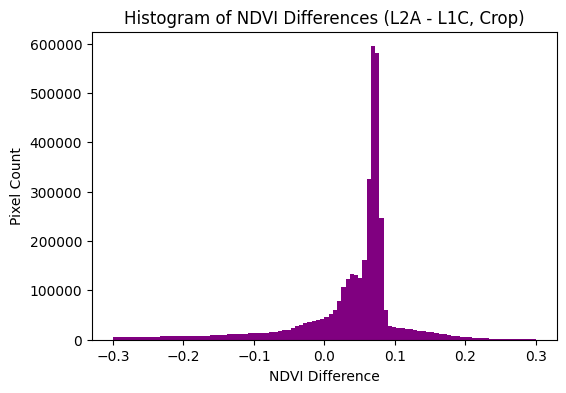

In [5]:
# 4) COMPUTE NDVI (L1C vs L2A) & VISUALIZE

ndvi_l1c = compute_ndvi(l1c_b08, l1c_b04)
ndvi_l2a = compute_ndvi(l2a_b08, l2a_b04)
ndvi_diff = ndvi_l2a - ndvi_l1c

plt.figure(figsize=(16,6))

# NDVI - L1C
plt.subplot(1,3,1)
plt.imshow(stretch(ndvi_l1c), cmap='RdYlGn')
plt.title("NDVI - L1C (Crop)")
plt.axis('off')

# NDVI - L2A
plt.subplot(1,3,2)
plt.imshow(stretch(ndvi_l2a), cmap='RdYlGn')
plt.title("NDVI - L2A (Crop)")
plt.axis('off')

# NDVI Difference
plt.subplot(1,3,3)
im = plt.imshow(ndvi_diff, cmap='RdBu', vmin=-0.2, vmax=0.2)
plt.colorbar(im, label="NDVI Diff (L2A - L1C)")
plt.title("NDVI Difference (Crop)")
plt.axis('off')

plt.tight_layout()
plt.show()

mean_diff = np.nanmean(ndvi_diff)
std_diff = np.nanstd(ndvi_diff)
print(f"Mean NDVI difference (L2A - L1C): {mean_diff:.4f}")
print(f"Std dev of NDVI difference: {std_diff:.4f}")

# Optional histogram of NDVI differences
plt.figure(figsize=(6,4))
plt.hist(ndvi_diff.flatten(), bins=100, range=(-0.3, 0.3), color='purple')
plt.title("Histogram of NDVI Differences (L2A - L1C, Crop)")
plt.xlabel("NDVI Difference")
plt.ylabel("Pixel Count")
plt.show()


## 5. K-Means Clustering on NDVI (L2A)

We apply unsupervised **K-Means clustering** to the NDVI map derived from Level-2A (surface reflectance) imagery. This allows us to segment the image into groups with similar vegetation characteristics, without using any labeled data.

### Method:
- The NDVI array is reshaped into a 1D feature vector:  
  $$ X \in \mathbb{R}^{n \times 1} $$
  where each pixel is represented by its NDVI value.
- We fit a **K-Means model with 4 clusters**, selected arbitrarily to capture general vegetation classes (e.g., bare soil, low, medium, and high vegetation).
- Cluster labels are reshaped back into 2D to visualize spatial patterns.

### Interpretation:
- Each color in the output map represents one of the four NDVI-based vegetation classes.
- The spatial layout of clusters reflects different vegetation zones or land cover types in the cropped Sentinel-2 scene.
- This method provides a baseline for unsupervised classification using spectral indices alone.

> K-Means is a useful clustering tool in remote sensing when ground-truth labels are not available. Later steps will expand this approach using additional features.


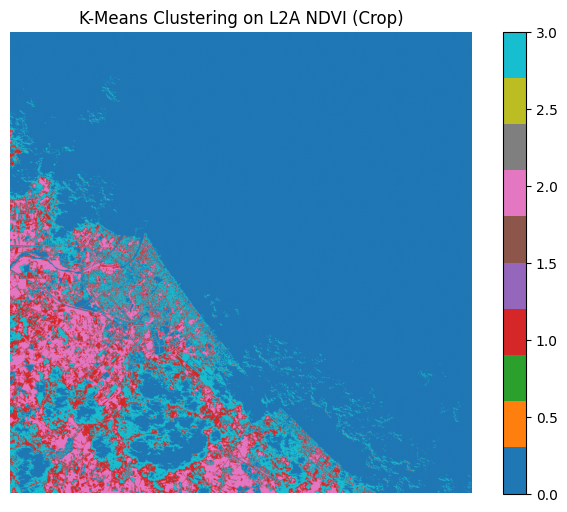

In [6]:
# 5) K-MEANS ON NDVI (L2A)
X_l2a = ndvi_l2a.reshape(-1, 1)  # shape: (n_pixels, 1)
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X_l2a)
labels_l2a = kmeans.labels_.reshape(ndvi_l2a.shape)

plt.figure(figsize=(8,6))
plt.imshow(labels_l2a, cmap='tab10')
plt.title("K-Means Clustering on L2A NDVI (Crop)")
plt.axis('off')
plt.colorbar()
plt.show()

## 6. Compute NDWI and Perform K-Means Clustering on (NDVI, NDWI)

We extend the clustering approach by incorporating both vegetation and water-related indices: **NDVI** and **NDWI**.

### NDWI Computation
The **Normalized Difference Water Index (NDWI)** is calculated using the formula:

$$
\text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR} + \varepsilon}
$$

Typically, the green band used is **Band 03**, but due to data availability, we approximate it using **Band 02 (Blue)**. This introduces some spectral shift but still provides a usable water proxy.

### Feature Stacking and Clustering
- We create a feature stack combining **NDVI and NDWI** for each pixel:  
  $$ X \in \mathbb{R}^{n \times 2} $$
- K-Means is then applied with **4 clusters**, now in a 2D feature space.
- This allows for more nuanced classification based on combined vegetation and water characteristics.

### Output
- The resulting cluster map is displayed, where each color represents a distinct spectral class based on NDVI and NDWI.
- This approach improves upon single-index clustering by capturing multiple surface characteristics simultaneously.

> This combined feature space provides better separation of water, vegetation, and transitional land types than using NDVI alone.


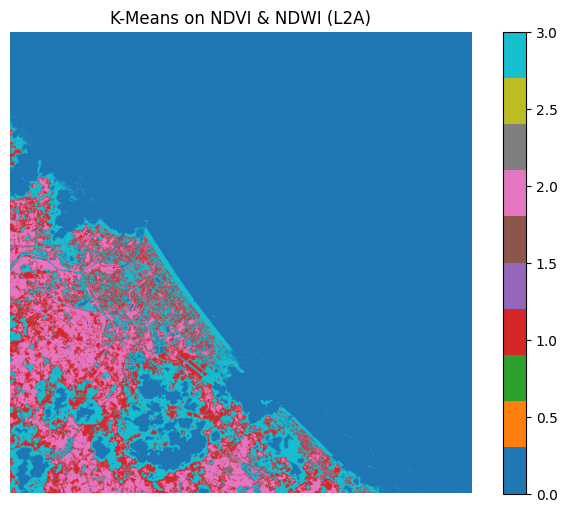

In [7]:
# 6) COMPUTE NDWI & K-MEANS ON (NDVI, NDWI)
#Typically NDWI uses GREEN (B03) - NIR (B08).
# Here we use l2a_b02 as "green".
def compute_ndwi(green, nir):
    return (green - nir) / (green + nir + 1e-6)

ndwi_l2a = compute_ndwi(l2a_b02, l2a_b08)

# Stack NDVI & NDWI
features_stack = np.dstack([ndvi_l2a, ndwi_l2a])  # shape: (rows, cols, 2)
X_stack = features_stack.reshape(-1, 2)

kmeans_2band = KMeans(n_clusters=4, random_state=0)
kmeans_2band.fit(X_stack)
labels_2band = kmeans_2band.labels_.reshape(features_stack.shape[:2])

plt.figure(figsize=(8,6))
plt.imshow(labels_2band, cmap='tab10')
plt.title("K-Means on NDVI & NDWI (L2A)")
plt.axis('off')
plt.colorbar()
plt.show()

## 7. Create and Visualize NDWI-Based Water Mask

To generate a baseline classification of water bodies, we apply a simple **thresholding method** to the NDWI values.

### Method:
- Pixels with **NDWI > 0** are classified as **water (value = 1)**.
- All other pixels are labeled as **land (value = 0)**.

This creates a binary water mask:

$$
\text{NDWI Mask}(x, y) =
\begin{cases}
1 & \text{if NDWI}(x, y) > 0 \\
0 & \text{otherwise}
\end{cases}
$$

### Output:
- The result is displayed as a binary image using a black-and-white colormap.
- This threshold-based classification is a widely used heuristic in water detection from satellite imagery.


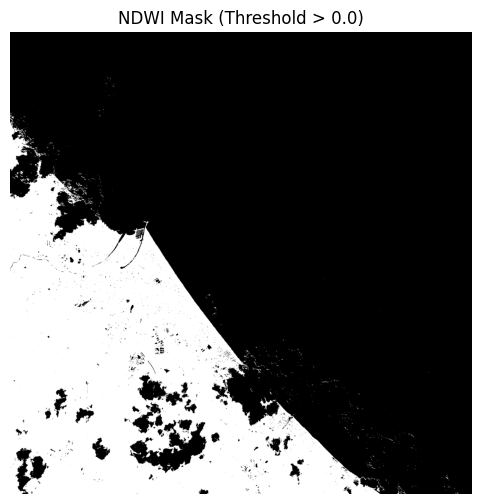

In [8]:
# 7) CREATE & DISPLAY A NDWI-THRESHOLD MASK
threshold = 0.0
ndwi_mask = (ndwi_l2a > threshold).astype(np.uint8)  # 1=water, 0=land

plt.figure(figsize=(6,6))
plt.imshow(ndwi_mask, cmap='binary')
plt.title(f"NDWI Mask (Threshold > {threshold})")
plt.axis('off')
plt.show()


## 8. Compare NDWI Mask with K-Means Prediction (Binary Classification)

To evaluate how well the **K-Means (NDVI + NDWI)** clustering aligns with the NDWI-based threshold mask, we map selected clusters to a binary classification:

### Method:
- Based on visual inspection, clusters **0 and 3** are assumed to represent water.
- We create a **binary K-Means mask** by reassigning those clusters to class 1 (water) and all others to 0 (land).
- We compare this against the NDWI mask using standard classification metrics.

### Evaluation:
- We compute:
  - **Confusion Matrix**
  - **Accuracy**
  - **Precision**, **Recall**, and **F1-score**
- The results are visualized both numerically (heatmap) and spatially (side-by-side maps of NDWI vs. K-Means binary outputs).

This step helps quantify the performance of the unsupervised clustering model against a threshold-based baseline.

> While the NDWI mask is not ground-truth, it provides a useful proxy for assessing the clustering effectiveness in identifying water pixels.


Confusion Matrix (NDWI vs. K-Means Binary):
[[ 646178  465211]
 [     12 2888599]]

Accuracy: 0.884

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.58      0.74   1111389
           1       0.86      1.00      0.93   2888611

    accuracy                           0.88   4000000
   macro avg       0.93      0.79      0.83   4000000
weighted avg       0.90      0.88      0.87   4000000



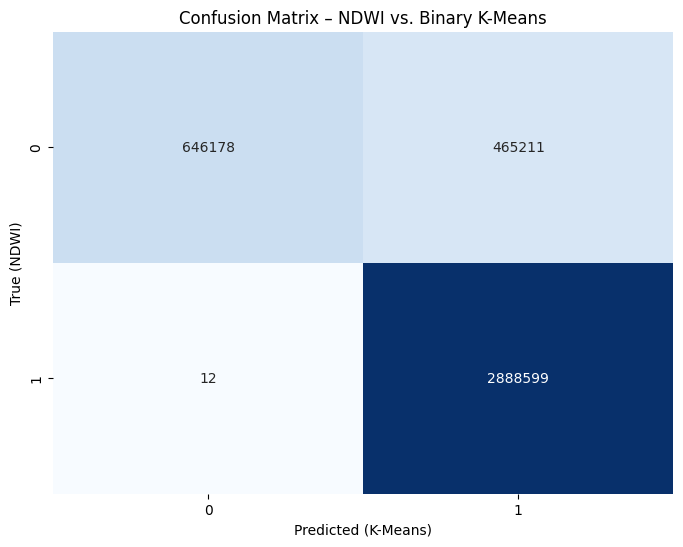

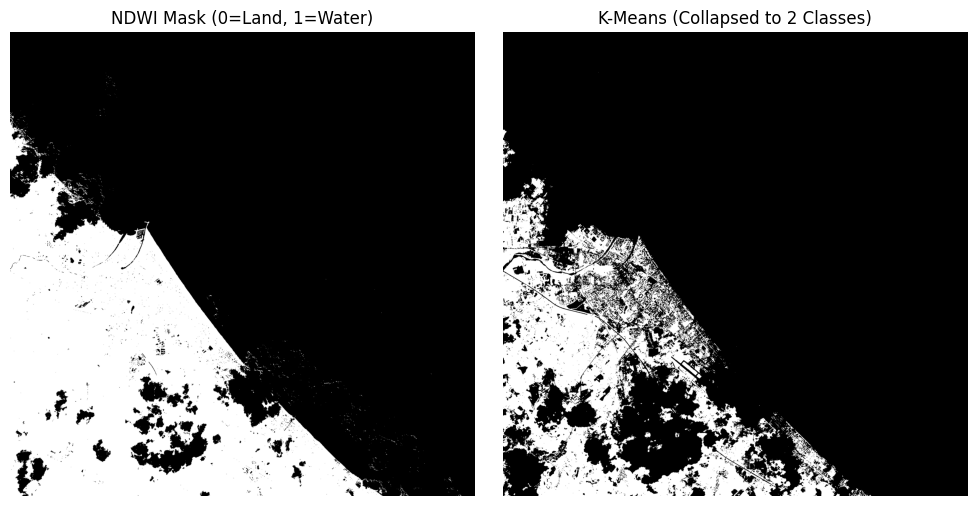

In [9]:
# 8) COMPARE NDWI MASK TO K-MEANS (2BAND)
# Choose which clusters are "water" in the 4-cluster result
# Suppose 0 and 3 appear to be water
water_cluster_ids = [0, 3]
kmeans_binary = np.isin(labels_2band, water_cluster_ids).astype(int)

# Flatten both for a confusion matrix
ndwi_baseline = ndwi_mask.flatten()  # shape: (n_pixels,)
kmeans_pred   = kmeans_binary.flatten()

if ndwi_baseline.shape != kmeans_pred.shape:
    print("Error: shapes do not match")
else:
    cm = confusion_matrix(ndwi_baseline, kmeans_pred)
    acc = accuracy_score(ndwi_baseline, kmeans_pred)
    rep = classification_report(ndwi_baseline, kmeans_pred)

    print("Confusion Matrix (NDWI vs. K-Means Binary):")
    print(cm)
    print(f"\nAccuracy: {acc:.3f}")
    print("\nClassification Report:\n", rep)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix – NDWI vs. Binary K-Means")
    plt.xlabel("Predicted (K-Means)")
    plt.ylabel("True (NDWI)")
    plt.show()

    # Side-by-side visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(ndwi_mask, cmap='binary')
    ax1.set_title("NDWI Mask (0=Land, 1=Water)")
    ax1.axis('off')
    ax2.imshow(kmeans_binary, cmap='binary')
    ax2.set_title("K-Means (Collapsed to 2 Classes)")
    ax2.axis('off')
    plt.tight_layout()
    plt.show()



## 9. Supervised Classification: Random Forest Using NDWI as Pseudo-Ground Truth

In this step, we implement a **supervised classification model** using a Random Forest (RF) algorithm, trained on pixel-wise spectral and index features. Since external labels are unavailable, we treat the binary **NDWI mask** as a proxy for ground truth.

### Feature Stack:
We use the following 5-band feature vector for each pixel:
- Band 2 (Blue)
- Band 4 (Red)
- Band 8 (Near-Infrared)
- NDVI
- NDWI

These are reshaped into a 2D array of shape *(n_pixels, 5)* for model training.

### Training and Evaluation:
- The dataset is split into training and testing subsets (70/30).
- A **Random Forest classifier** with 100 trees is trained to classify each pixel as water or non-water.
- Evaluation is performed using:
  - **Confusion matrix**
  - **Accuracy**
  - **Precision, Recall, F1-score** (via `classification_report`)

### Output:
- A heatmap displays the confusion matrix.
- Classification performance metrics are printed to assess model accuracy and class balance.

> This model tests whether machine learning can replicate NDWI-based classification using a richer spectral feature set. A high-performing RF model demonstrates that physical indices can be learned and generalized through supervised learning techniques.



=== Random Forest vs. NDWI Baseline ===
Confusion Matrix:
 [[333417      0]
 [     0 866583]]
Accuracy: 1.000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    333417
           1       1.00      1.00      1.00    866583

    accuracy                           1.00   1200000
   macro avg       1.00      1.00      1.00   1200000
weighted avg       1.00      1.00      1.00   1200000



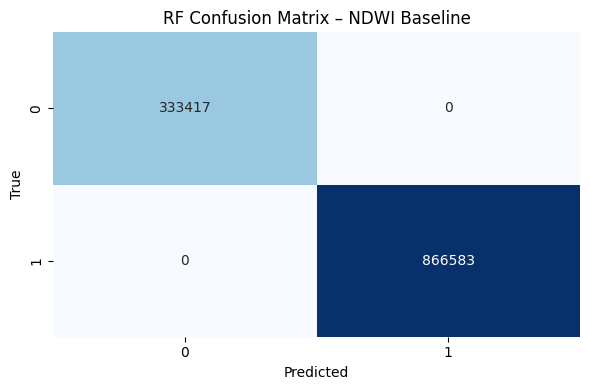

In [10]:
# 9) USE NDWI MASK AS “GROUND TRUTH” FOR RF
##############################################
# Instead of external labels, treat NDWI mask as baseline
y_all = ndwi_mask.flatten()  # shape: (n_pixels,)

# Build a feature stack: (B02, B04, B08, NDVI, NDWI)
features = np.dstack([l2a_b02, l2a_b04, l2a_b08, ndvi_l2a, ndwi_l2a])
X_all = features.reshape(-1, features.shape[-1])  # shape: (n_pixels, 5)

# Train/test split
if len(np.unique(y_all)) > 1:
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.3, random_state=42, stratify=y_all
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=0.3, random_state=42
    )
    print("WARNING: NDWI baseline is all 0 or all 1.")

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
rep = classification_report(y_test, y_pred)

print("\n=== Random Forest vs. NDWI Baseline ===")
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {acc:.3f}")
print("Classification Report:\n", rep)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("RF Confusion Matrix – NDWI Baseline")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## 11. Dimensionality Reduction with PCA and UMAP

To visualize the high-dimensional feature space and assess the internal structure of spectral data, we apply two dimensionality reduction techniques:

### Step 1: Standardization
All 5 input features — Band 2, Band 4, Band 8, NDVI, and NDWI — are standardized using z-score normalization to ensure equal scaling across dimensions.

### Step 2: PCA (Principal Component Analysis)
We reduce the 5D feature space to 2D using PCA:
- PCA preserves **global variance structure**
- The resulting plot shows clusters formed by K-Means
- Principal components are linear combinations of input features

**Interpretation:**  
- Cluster 0 (likely water) forms a compact region.
- Vegetation-related clusters appear more dispersed.
- PCA confirms that NDVI + NDWI contribute significantly to separability.

### Step 3: UMAP (Uniform Manifold Approximation and Projection)
To capture **nonlinear relationships**, we also apply UMAP:
- A sample of 100,000 pixels is used to reduce memory usage.
- UMAP focuses on preserving local structure (neighborhood similarity).

**Interpretation:**  
- UMAP visualizes finer separation between K-Means clusters.
- The curved or folded shape is expected — it reflects **manifold geometry**, not spatial layout.
- Cluster boundaries are tighter, supporting the meaningfulness of the spectral feature space.

> These visualizations help confirm that K-Means is not arbitrarily grouping pixels — the input features contain true separability in both linear and nonlinear projections.


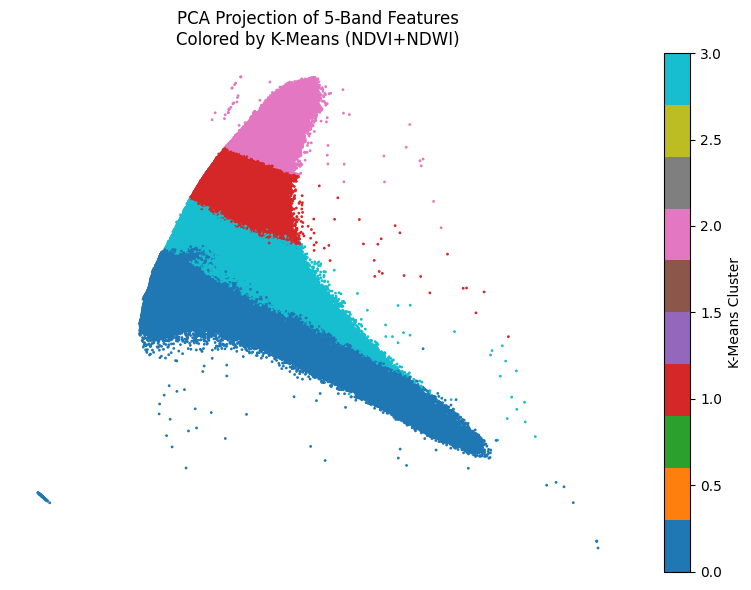

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


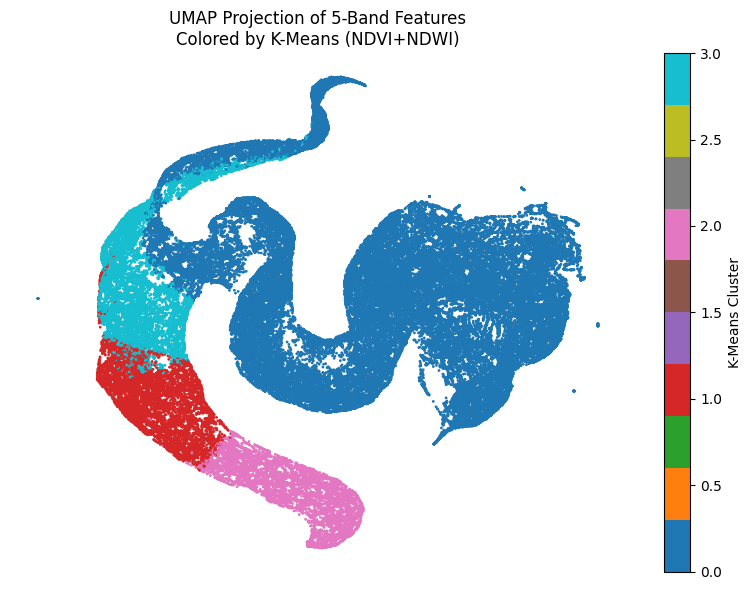

In [11]:
# =============================
# 10) Dimensionality Reduction (PCA & UMAP)
# =============================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np

# 1. Standardize the features (B02, B04, B08, NDVI, NDWI)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

# 2. Perform PCA (keep only 2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# PCA plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_2band.flatten(), cmap='tab10', s=1)
plt.title("PCA Projection of 5-Band Features\nColored by K-Means (NDVI+NDWI)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.axis('off')
plt.colorbar(label='K-Means Cluster')
plt.tight_layout()
plt.show()

# 3. Optional: downsample to avoid UMAP memory issues
sample_size = 100000  # Max number of pixels for UMAP
if X_scaled.shape[0] > sample_size:
    idx = np.random.choice(X_scaled.shape[0], size=sample_size, replace=False)
    X_umap_input = X_scaled[idx]
    labels_umap = labels_2band.flatten()[idx]
else:
    X_umap_input = X_scaled
    labels_umap = labels_2band.flatten()

# 4. Run UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_umap_input)

# UMAP plot
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels_umap, cmap='tab10', s=1)
plt.title("UMAP Projection of 5-Band Features\nColored by K-Means (NDVI+NDWI)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.axis('off')
plt.colorbar(label='K-Means Cluster')
plt.tight_layout()
plt.show()